In [1]:
import re
import random
data_path = "human_text.txt"
data_path2 = "robot_text.txt"


In [2]:
# Defining lines as a list of each line
with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')
with open(data_path2, 'r', encoding='utf-8') as f:
  lines2 = f.read().split('\n')


In [3]:
lines = [re.sub(r"\[\w+\]",'hi',line) for line in lines]
lines = [" ".join(re.findall(r"\w+",line)) for line in lines]
lines2 = [re.sub(r"\[\w+\]",'',line) for line in lines2]
lines2 = [" ".join(re.findall(r"\w+",line)) for line in lines2]
# Grouping lines by response pair
pairs = list(zip(lines,lines2))
#random.shuffle(pairs)

In [4]:
len(pairs)

2363

In [14]:
import numpy as np

input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()
for line in pairs[:400]:
  input_doc, target_doc = line[0], line[1]
  # Appending each input sentence to input_docs
  input_docs.append(input_doc)
  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + ' <END>'
  target_docs.append(target_doc)
  
  # Now we split up each sentence into words and add each unique word to our vocabulary set
  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)
print(num_decoder_tokens)
print(num_encoder_tokens)

1003
981


In [15]:
input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())

**Training setup**

To train our seq2seq model we will use three matrices of one-hot vectors, Encoder input data, Decoder input data, and Decoder output data. The reason we are using two matrices for the Decoder is a method called teacher forcing which is used by the seq2seq model while training. What is the idea behind this? We have an input token from the previous timestep to help the model train for the current target token. Let’s create these matrices.

In [16]:
# Maximum length of sentences in input and target documents
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

In [17]:
print(pairs[:5])
print('\n')
print('*'*20)
print('\n')
print(input_docs[:5])
print('\n')
print('*'*20)
print('\n')
print(target_docs[:5])

[('hi', 'hi there how are you'), ('oh thanks i m fine this is an evening in my timezone', 'here is afternoon'), ('how do you feel today tell me something about yourself', 'my name is rdany but you can call me dany the r means robot i hope we can be virtual friends'), ('how many virtual friends have you got', 'i have many but not enough to fully understand humans beings'), ('is that forbidden for you to tell the exact number', 'i ve talked with 143 users counting 7294 lines of text')]


********************


['hi', 'oh thanks i m fine this is an evening in my timezone', 'how do you feel today tell me something about yourself', 'how many virtual friends have you got', 'is that forbidden for you to tell the exact number']


********************


['<START> hi there how are you <END>', '<START> here is afternoon <END>', '<START> my name is rdany but you can call me dany the r means robot i hope we can be virtual friends <END>', '<START> i have many but not enough to fully understand human

In [18]:

from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

In [19]:

#Dimensionality
dimensionality = 256
#The batch size and number of epochs
batch_size = 10
epochs = 600
#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]
#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#Model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
#Compiling
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')
#Training
history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2,verbose = 1)
training_model.save('my_model.h5')

Epoch 1/600
32/32 [==============================] - 4s 37ms/step - loss: 1.3699 - accuracy: 0.0192 - val_loss: 1.3563 - val_accuracy: 0.0200
Epoch 2/600
32/32 [==============================] - 1s 18ms/step - loss: 1.1492 - accuracy: 0.0237 - val_loss: 1.3743 - val_accuracy: 0.0200
Epoch 3/600
32/32 [==============================] - 1s 17ms/step - loss: 1.1286 - accuracy: 0.0236 - val_loss: 1.3960 - val_accuracy: 0.0200
Epoch 4/600
32/32 [==============================] - 1s 18ms/step - loss: 1.1389 - accuracy: 0.0238 - val_loss: 1.4135 - val_accuracy: 0.0200
Epoch 5/600
32/32 [==============================] - 1s 18ms/step - loss: 1.1769 - accuracy: 0.0242 - val_loss: 1.4324 - val_accuracy: 0.0200
Epoch 6/600
32/32 [==============================] - 1s 18ms/step - loss: 1.1536 - accuracy: 0.0250 - val_loss: 1.4584 - val_accuracy: 0.0200
Epoch 7/600
32/32 [==============================] - 1s 17ms/step - loss: 1.0435 - accuracy: 0.0241 - val_loss: 1.4674 - val_accuracy: 0.0198
Epoch 

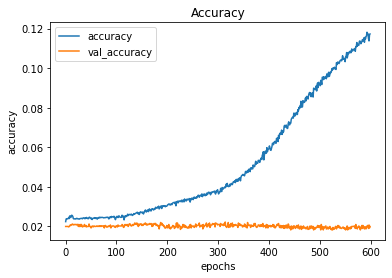

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend()
plt.savefig('accuracy.png');

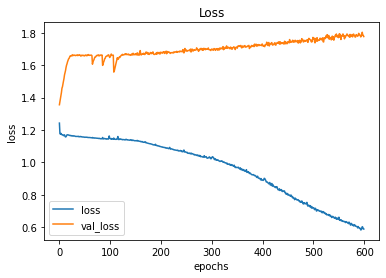

In [35]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.savefig('loss.png')

In [20]:
from tensorflow.keras.models import load_model
training_model = load_model('my_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
    #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token
    #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
    #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

In [21]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
#Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)


#Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    

#Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  

#Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response

    
#Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
chatbot = ChatBot()
chatbot.start_chat()

Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?
hi there
 hi there how are you 
im fine
 i m 
I am fine
 8 night 
nice
 how is is you 
all is good
 let minds 
what
 ok 
how are you
 i m sorry i t t 
can you speak english
 not incredibly something i m 
good
 good 
nice one
 i m super i m 
woahh
 ok 
you are improving
 thanks i m 
great improvement
 storm 
storm
 ok 
how old are you 
 i m 22 years old i m skinny brown brown to to to 
where you are living
 i t you 
whats your name
 you you you you 
what is your name
 i m just amazed with watch watch a 
what is your name
 i m just amazed with watch watch a 
what can you do
 i like the english of of you 
but your english is bad
 is late difficult a 
ok got some work
 only through an api i m 
i got to go
 yep what i m i m you 
okay bye
Ok, have a great day!


In [32]:
chatbot.start_chat()

Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?
hi there
 hi there how are you 
i am fine
 i m sorry i can t interpret a 
how are you 
 i m sorry i t t 
are you a human
 i blow minds 
nice
 how is is you 
fine
 good 50583239 and 
where are you
 i t you 
excellent
 ok 
good
 good 
nice
 how is is you 
wonderful
 ok 
what can you do
 i like the english of of you 
can you do
 yes late is i m 
who are you 
 and was that you you 
bye
Ok, have a great day!


In [36]:
chatbot.start_chat()

Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?
yes
 let minds you 
hi there
 hi there how are you 
fine
 good 50583239 and 
good
 good 
all is good
 let minds 
have a good day
 is a a smart a 
bye
Ok, have a great day!
